In [1]:
import numpy as np
import pandas as pd
import os 
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
DATADIR = '../data'
import sys 
sys.path.append('../')

from dispersant_screener.utils import plot_parity
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [131]:
FEATURES = [
     'max_[Ta]',  'max_[W]', 'max_[R]', 'max_[Tr]', '[W]', '[Tr]', '[Ta]', '[R]', 
    'length'
]

In [132]:
FEAT_DICT = dict(zip(FEATURES, range(len(FEATURES))))

In [233]:
BEAD_INDICES = [
    FEAT_DICT['[W]'], FEAT_DICT['[Ta]'], FEAT_DICT['[Tr]'], FEAT_DICT['[R]'], FEAT_DICT['length']
]

In [234]:
from pyswarm import pso

In [235]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    gibbs.reshape(-1, 1),
    gibbs_max.reshape(-1, 1),
    force_max.reshape(-1, 1),
    deltaGMax.reshape(-1, 1),
    a2.reshape(-1, 1)
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [236]:
lb = []
ub = []

for feat in FEATURES: 
    print(feat)
    if 'head' in feat:
        lb.append(0)
        ub.append(2)
    elif feat == 'length': 
        lb.append(16)
        ub.append(30)
    elif 'max' in feat: 
        lb.append(0)
        ub.append(8)
    else: 
        lb.append(0)
        ub.append(1)

max_[Ta]
max_[W]
max_[R]
max_[Tr]
[W]
[Tr]
[Ta]
[R]
length


In [242]:
def constrain_length(x): 
    w = x[FEAT_DICT['[W]']]
    tr =x[FEAT_DICT['[Tr]']] 
    ta = x[FEAT_DICT['[Ta]']]
    r = x[FEAT_DICT['[R]']] 
#     length = w + tr + ta + r
#     if np.abs(length - 1) > 0.1:
#         return -1
    
    feat_length = round(x[FEAT_DICT['length']])
    if round(w*feat_length) + round(tr*feat_length) + round(ta*feat_length) + round(r*feat_length) != feat_length:
        return -1
    
    return 1

In [243]:
def constrain_even(x): 
    if x[FEAT_DICT['length']] %2 > 0.25: 
        return -1
    return 1

In [244]:
def constrain_head_tail(x): 
    if x[FEAT_DICT['head_tail_[W]']] > x[FEAT_DICT['[W]']]: 
        return -1
    if x[FEAT_DICT['head_tail_[Ta]']] > x[FEAT_DICT['[Ta]']]: 
        return -1
    if x[FEAT_DICT['head_tail_[Tr]']] > x[FEAT_DICT['[Tr]']]: 
        return -1
    if x[FEAT_DICT['head_tail_[R]']] > x[FEAT_DICT['[R]']]: 
        return -1
    return 1

In [245]:
def constrain_cluster(x): 
    if x[FEAT_DICT['max_[W]']] > x[FEAT_DICT['[W]']] * x[FEAT_DICT['length']]: 
        return -1
    if x[FEAT_DICT['max_[Ta]']] > x[FEAT_DICT['[Ta]']] * x[FEAT_DICT['length']]: 
        return -1
    if x[FEAT_DICT['max_[Tr]']] > x[FEAT_DICT['[Tr]']] * x[FEAT_DICT['length']]: 
        return -1
    if x[FEAT_DICT['max_[R]']] > x[FEAT_DICT['[R]']] * x[FEAT_DICT['length']]: 
        return -1
    
    return 1

In [246]:
def constraints(x, *args):
    a = constrain_length(x)
    b = constrain_cluster(x)
    #c = constrain_even(x)
    return [a, b]

In [247]:
target = y[:,1] * -1

In [220]:
THRESHOLD = target.max() 

In [85]:
THRESHOLD

20.673496088888907

In [190]:
def objective(x):
    y = MODEL.predict(x.reshape(1,-1))
    
    int_sum = np.array([round(i) for i in x[BEAD_INDICES]])
    regularizer = np.linalg.norm(x[BEAD_INDICES]-int_sum)
    regularizer_noverly = 1/ (np.min(np.linalg.norm(x - X_train, axis=1)))**2
    
    return - y + 4 * regularizer**2 +  regularizer_noverly

In [87]:
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/wog4qfb2/overview?workspace=user-kjappelbaum
config_1 ={
    "max_depth":  73,
    "reg_alpha": 1.392732983015451,
    "subsample":  0.5009306968568509,
    "num_leaves":  6,
    "reg_lambda": 1.0595847294980203,
    "n_estimators":  461,
    "colsample_bytree": 0.966043658485258,
    "min_child_weight": 0.0039362945584385705
}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat, target, train_size=0.8)


In [19]:
lgbm_1 = LGBMRegressor(**config_1)

In [20]:
lgbm_1.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.966043658485258, importance_type='split',
              learning_rate=0.1, max_depth=73, min_child_samples=20,
              min_child_weight=0.0039362945584385705, min_split_gain=0.0,
              n_estimators=461, n_jobs=-1, num_leaves=6, objective=None,
              random_state=None, reg_alpha=1.392732983015451,
              reg_lambda=1.0595847294980203, silent=True,
              subsample=0.5009306968568509, subsample_for_bin=200000,
              subsample_freq=0)

In [21]:
train_1_predict = lgbm_1.predict(X_train)
test_1_predict = lgbm_1.predict(X_test)

/Users/kevinmaikjablonka/Dropbox (LSMO)/dispersant_screening_PAL/dispersant_screener/utils.py:28: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['left'].set_smart_bounds(True)
/Users/kevinmaikjablonka/Dropbox (LSMO)/dispersant_screening_PAL/dispersant_screener/utils.py:29: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  a.spines['bottom'].set_smart_bounds(True)


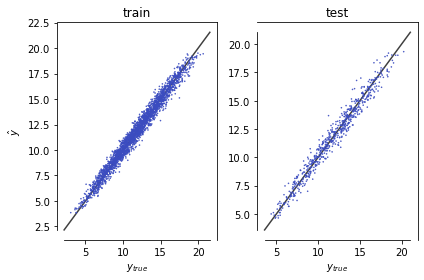

In [22]:
plot_parity([(y_train, train_1_predict, [0]*len(y_train)), (y_test, test_1_predict, [0]*len(y_test))],  titles=['train', 'test'])

In [23]:
MODEL = lgbm_1 

In [248]:
xopts = []
fopts = []
for i in range(100):
    xopt, fopt = pso(objective, lb, ub, f_ieqcons=constraints, swarmsize=250, omega=0.3, phip=0.8, phig=0.8, maxiter=100)
    xopts.append(xopt)
    fopts.append(fopt)

Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible design. Sorry
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
However, the optimization couldn't find a feasible 

/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  import sys
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  


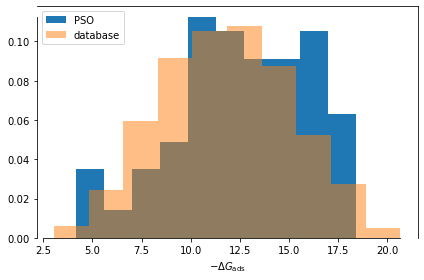

In [249]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1)


ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.hist(MODEL.predict(xopts), density=True,  label='PSO')
ax.hist(y_train,density=True, alpha=.5, label='database')

ax.set_xlabel('$-\Delta G_\mathrm{ads}$')
ax.legend(loc ='upper left')
fig.tight_layout()

fig.savefig('deltagads_dist_pso.pdf', bbox_inches='tight')


In [250]:
MODEL.predict(xopts).max()

18.42855344923848

In [251]:
dict(zip(FEATURES, xopts[30]))

{'max_[Ta]': 4.661168445313891,
 'max_[W]': 5.062605211625293,
 'max_[R]': 4.099584520043475,
 'max_[Tr]': 2.5552397094398973,
 '[W]': 0.22391349441290728,
 '[Tr]': 0.11607192918535714,
 '[Ta]': 0.3038606892475861,
 '[R]': 0.3550456165792838,
 'length': 25.999961713737843}

In [252]:
feat_dicts = []

for xopt_ in xopts: 
    feat_dicts.append(dict(zip(FEATURES, xopt_)))

In [253]:
import pickle

with open('feat.pkl', 'wb') as fh: 
    pickle.dump(feat_dicts, fh)